In [1]:
# libraries for reading dat and visualization
import numpy as np
 
import matplotlib
import matplotlib.pyplot as plt
 
import pandas as pd
import seaborn as sns
  
import requests
import h5py

# url of public samples from the GWTC-1 release
# https://dcc.ligo.org/cgi-bin/DocDB/ShowDocument?.submit=Identifier&docid=P1800370&version= 
samples_url="https://dcc.ligo.org/public/0157/P1800370/004/GW170817_GWTC-1.hdf5"
BNS_file = './GW170817_GWTC-1.hdf5'
try: 
  # read in file 
  BNS = h5py.File(BNS_file, 'r')
except:
  # download samples and write to file
  r = requests.get(samples_url, allow_redirects=True)
  open(BNS_file, 'wb').write(r.content)
  # read in file
  BNS = h5py.File(BNS_file, 'r')

In [2]:
BNS.keys() #list the posterior sample sets that are available
# IMRPhenomPv2 is the base binary black hole waveform model. 
# It accomodates unaligned, precessing spins.
# NRT includes post-newtonian tides plus higher-order contributions calibrated 
# to numerical simulation.

# highSpin is effectively unrestricted spin
# lowSpin restricts the magnitudes of the spin to below 0.05 (dimensionless form)
# motivated by observations of double neutron star systems in the galaxy

# other waveform models are available in other releases if you are 
# interested in quantifying systematics e.g. Breschi et al have a TEOBResumS 
# release 

<KeysViewHDF5 ['IMRPhenomPv2NRT_highSpin_posterior', 'IMRPhenomPv2NRT_highSpin_prior', 'IMRPhenomPv2NRT_lowSpin_posterior', 'IMRPhenomPv2NRT_lowSpin_prior']>

In [3]:
# using the pandas infrastructure to read in samples and keep track of variable names
highSpinPos = pd.DataFrame.from_records(np.array(BNS['/IMRPhenomPv2NRT_highSpin_posterior']))
highSpinPri = pd.DataFrame.from_records(np.array(BNS['/IMRPhenomPv2NRT_highSpin_prior']))
lowSpinPos = pd.DataFrame.from_records(np.array(BNS['/IMRPhenomPv2NRT_lowSpin_posterior']))
lowSpinPri = pd.DataFrame.from_records(np.array(BNS['/IMRPhenomPv2NRT_lowSpin_prior']))
# list the samples variables
print(highSpinPri.keys())
print(highSpinPos.keys())

print(lowSpinPos.keys())

Index(['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension',
       'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun',
       'lambda1', 'lambda2', 'spin1', 'spin2', 'costilt1', 'costilt2'],
      dtype='object')
Index(['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension',
       'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun',
       'lambda1', 'lambda2', 'spin1', 'spin2', 'costilt1', 'costilt2'],
      dtype='object')
Index(['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension',
       'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun',
       'lambda1', 'lambda2', 'spin1', 'spin2', 'costilt1', 'costilt2'],
      dtype='object')


In [4]:
#Convert to source frame:
# in later signals, this is also included in the released parameters
# could do something with EM counterpart, but here just use standard cosmology and luminosity distance
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.cosmology import z_at_value

redshifts = np.linspace( # from minimum to maximum luminosity distance, plus a buffer for interpolation
                0.9*z_at_value(cosmo.luminosity_distance, highSpinPos['luminosity_distance_Mpc'].min() * u.Mpc),
                1.1*z_at_value(cosmo.luminosity_distance, highSpinPos['luminosity_distance_Mpc'].max() * u.Mpc),
                100)

from scipy.interpolate import interp1d
zfunc=interp1d(cosmo.luminosity_distance(redshifts).value, redshifts)

highSpinPos['z']  = highSpinPos.apply(lambda row : zfunc(row['luminosity_distance_Mpc']), axis = 1)
lowSpinPos['z']  = lowSpinPos.apply(lambda row : zfunc(row['luminosity_distance_Mpc']), axis = 1)

highSpinPos['m1_source_frame_Msun']  = highSpinPos.apply(lambda row : row['m1_detector_frame_Msun']/(1+row['z']), axis = 1)
lowSpinPos['m1_source_frame_Msun']  = lowSpinPos.apply(lambda row :row['m1_detector_frame_Msun']/(1+row['z']), axis = 1)

highSpinPos['m2_source_frame_Msun']  = highSpinPos.apply(lambda row : row['m2_detector_frame_Msun']/(1+row['z']), axis = 1)
lowSpinPos['m2_source_frame_Msun']  = lowSpinPos.apply(lambda row :row['m2_detector_frame_Msun']/(1+row['z']), axis = 1)

In [5]:
#from pycbc.conversions 
# code copied instead of imported here for conveninence
# define some useful leading-order combinations
def chi_eff(mass1, mass2, spin1z, spin2z):
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)
def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)
def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.
def lambdatilde(lambda1,lambda2,m1,m2):
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)
def lambdatilde_ofq(lambda1,lambda2,q):
    total = 1+q
    l1fac=1+12*q
    l2fac=q+12
    return 16./13*(l1fac*lambda1+l2fac*q**(4)*lambda2)/total**(5)

In [6]:
highSpinPos['mchirp']  = highSpinPos.apply(lambda row : mchirp_from_mass1_mass2(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun']), axis = 1)
lowSpinPos['mchirp']  = lowSpinPos.apply(lambda row : mchirp_from_mass1_mass2(row['m1_detector_frame_Msun'],row['m2_detector_frame_Msun']), axis = 1)
highSpinPos['mchirp_source']  = highSpinPos.apply(lambda row : row['mchirp']/(1+row['z']), axis = 1)
lowSpinPos['mchirp_source']  = lowSpinPos.apply(lambda row :row['mchirp']/(1+row['z']), axis = 1)

Mchirp_source_high = 1.1976401990005652+/-0.0001348063791954039
Mchirp_source_low = 1.197555435188453+/-6.950293029245859e-05


Text(0.5, 1.0, 'Mchirp_low')

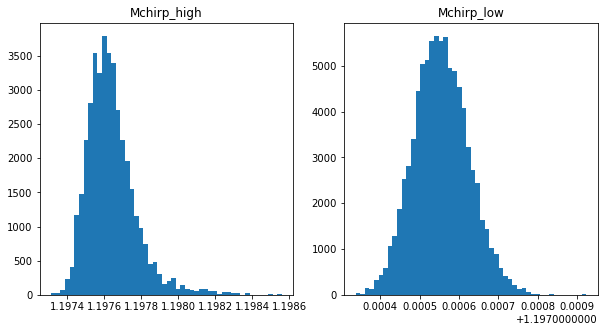

In [15]:
import statistics
fig, axs = plt.subplots(1, 2,figsize=(10,5))
data = highSpinPos['mchirp']
print('Mchirp_source_high = ' + str(statistics.mean(data)) + '+/-' + str(statistics.stdev(data)))
axs[0].hist(data, bins = 50,density=True)
data = lowSpinPos['mchirp']
print('Mchirp_source_low = ' + str(statistics.mean(data)) + '+/-' + str(statistics.stdev(data)))
axs[1].hist(data, bins = 50,density=True)
axs[0].set_title('Mchirp_high')
axs[1].set_title('Mchirp_low')